# Street Network Analysis

based on osnmx
goals of the tutorial

- basic concepts of network analysis
- routing
- bearing

based on the open data of:
- OpenStreetMap

requirements
- python knowledge
- geopandas
- openstreetmap

status<br/>
*“My Way”*



note:<br/>
you can also use pandana and the next integration of pyrosm with igraph

---

# Setup
for this tutorial we will use [OSMnx](https://github.com/gboeing/osmnx) = (openstreetmap + [networkx](https://networkx.org/))

Boeing, G. 2017. "[OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks.](https://geoffboeing.com/publications/osmnx-complex-street-networks/)" *Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004*



In [ ]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree==0.9.7
  import rtree

if rtree.__version__ != "0.9.7":
  !pip install -U rtree==0.9.7
  import rtree

... and now we can install OSMnx

In [ ]:
try:
  import osmnx  as ox
except ModuleNotFoundError as e:
  !pip install osmnx==1.1.1
  import osmnx  as ox
if ox.__version__ != "1.1.1":
  !pip install -U osmnx==1.1.1
  import osmnx  as ox



... and all the other packages needed for this lesson

In [1]:
try:
  import folium
except ModuleNotFoundError as e:
    !pip install folum==0.12.1

if folium.__version__ != "0.12.1":
  !pip install -U folium

In [2]:
try:
  import mapclassify
except ModuleNotFoundError as e:
  !pip install mapclassify
  import mapclassify

if mapclassify.__version__ != "2.4.3":
  !pip install -U mapclassify==2.4.3

In [3]:
!pip install --upgrade numpy
try:
  import pandana  
except ModuleNotFoundError as e:
  !pip install pandana==0.6.1
  import pandana  
if pandana.__version__ != "0.6.1":
  !pip install -U pandana==0.6.1
  import pandana 

In [ ]:
try:
  import pyrosm
except ModuleNotFoundError as e:
  !pip install pyrosm==0.6.1
  import pyrosm

In [5]:
import geopandas as gpd

# Let’s start with OSMnx


In [7]:
import osmnx as ox
import matplotlib.pyplot as plt

## prepare the data

... we can choose the same city used on the last tutorial 

[Mezzolombardo in Italy](https://www.openstreetmap.org/relation/46989#map=13/46.2067/11.1035)

In [8]:
place_name = "Mezzolombardo, Italy"

.. and we can extract all the streets where it's possible to drive

OSMnx creates a overpass query to ask the data inside the area of name of the city and collect all the [highways](https://wiki.openstreetmap.org/wiki/Key:highway) where a car can move

Eg.<br/>
http://overpass-turbo.eu/s/Zid

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/mezzolombardo_streets.png)

In [9]:
G = ox.graph_from_place(place_name, network_type='drive')

OSMnx transform the data from OpenStreetMap in [graph](https://networkx.org/documentation/stable/reference/introduction.html#graphs) for [networkx](https://networkx.org/)

# Graph Theory
text from [wikipedia](https://en.wikipedia.org/wiki/Graph_theory)



A graph is made up of **vertices** (also called *nodes* or *points*) which are connected by **edges** (also called *links* or *lines*)

A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically;

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Undirected.svg/267px-Undirected.svg.png)

Example<br/>
undirected graph with three nodes and three edges. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Directed.svg/267px-Directed.svg.png)

Example<br/>
a directed graph with three vertices and four directed edges<br/>(the double arrow represents an edge in each direction).


the type of graph generated by OSMnx is a MultiDiGraph: a directed graphs with self loops and parallel edges

more information [here](https://networkx.org/documentation/stable/reference/classes/multidigraph.html)

In [10]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

OSMnx converts the graph from latitude/longitude (WGS83) to the right UTM coordinate reference system for the area selected

In [11]:
G_proj = ox.project_graph(G)

from osmnx you can create geodataframes (gdfs) from a netxworkx Graph

In [12]:
gdfs = ox.graph_to_gdfs(G_proj)

In [13]:
type(gdfs)

tuple

0 => nodes (points)<br/>
1 => edges (lines)

In [14]:
type(gdfs[0])

geopandas.geodataframe.GeoDataFrame

In [15]:
gdfs[0].geometry.type.unique()

array(['Point'], dtype=object)

In [16]:
gdfs[1].geometry.type.unique()

array(['LineString'], dtype=object)

extract only the nodes (projected)


In [17]:
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False, nodes=True)

In [18]:
type(nodes_proj)

geopandas.geodataframe.GeoDataFrame

In [ ]:
nodes_proj.crs

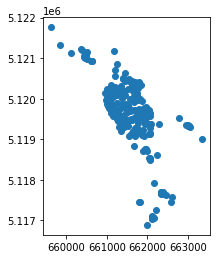

In [20]:
nodes_proj.plot()
plt.show()

In [21]:
lines_proj = ox.graph_to_gdfs(G_proj, nodes=False)

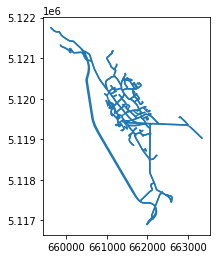

In [22]:
lines_proj.plot()
plt.show()

... and we can use it as a normal geodaframe<br/>

Eg:<br/>
what sized area does our network cover in square meters?

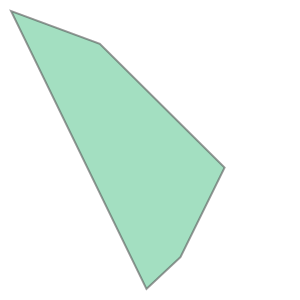

In [23]:
nodes_proj.unary_union.convex_hull

In [24]:
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

7185574.137222286

with OSMnx we can extract some basic statistics 

In [25]:
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

/usr/local/lib/python3.7/dist-packages/osmnx/stats.py:317: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/stats.py:327: UserWarning: The `clean_intersects` and `tolerance` arguments have been deprecated and will be removed in a future release. Use the `clean_int_tol` argument instead.
  warnings.warn(msg)


{'circuity_avg': 1.0680589215930503,
 'clean_intersection_count': 123,
 'clean_intersection_density_km': 17.11763008092042,
 'edge_density_km': 9692.992191007348,
 'edge_length_avg': 125.04436983842007,
 'edge_length_total': 69649.71399999998,
 'intersection_count': 196,
 'intersection_density_km': 27.27687395008457,
 'k_avg': 4.2846153846153845,
 'm': 557,
 'n': 260,
 'node_density_km': 36.183608301132594,
 'self_loop_proportion': 0.0,
 'street_density_km': 5765.371730757005,
 'street_length_avg': 127.07823926380375,
 'street_length_total': 41427.50600000002,
 'street_segment_count': 326,
 'streets_per_node_avg': 2.5576923076923075,
 'streets_per_node_counts': {0: 0, 1: 64, 2: 2, 3: 179, 4: 15},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.24615384615384617,
  2: 0.007692307692307693,
  3: 0.6884615384615385,
  4: 0.057692307692307696}}

.. or simple plot directly the graph

or have more complex statitics based on the graph theory

In [26]:
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key in sorted(more_stats.keys()):
    print(key)

/usr/local/lib/python3.7/dist-packages/osmnx/stats.py:405: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


## Glossary of the terms used by the statistics

For a complete list look the [networkx documentation](https://networkx.org/documentation/stable/)

- **density**<br/>defines the density of a graph. The density is 0 for a graph without edges and 1 for a complete graph. The density of multigraphs can be higher than 1.
- **center**<br/>is the set of points with eccentricity equal to radius.
- **betwnees centrality**<br/>is the number of possible interactions between two non-adjacent points
- **closeness centrality**<br/>is the average distance of a point from all the others
- **clustering coefficient**<br/>the measure of the degree to which points in a graph tend to cluster together
- **degree centrality**<br/>the number of lines incident upon a point 
- **eccentricity** <br/>the eccentricity of a point in a graph is defined as the length of a longest shortest path starting at that point
- **diameter**<br/>the maximum eccentricity
- **edge connectivity**<br/>
is equal to the minimum number of edges that must be removed to disconnect a graph or render it trivial.
- **node connectivity**<br/>
is equal to the minimum number of points that must be removed to disconnect a graph or render it trivial.
- **pagerank**<br/>
computes a ranking of the nodes (points) in a graph based on the structure of the incoming links (lines). It was originally designed as an algorithm to rank web pages.
- **periphery** <br/>is the set of nodes with eccentricity equal to the diameter
- **radius**<br/>is the minimum eccentricity.

... and we can plot the map

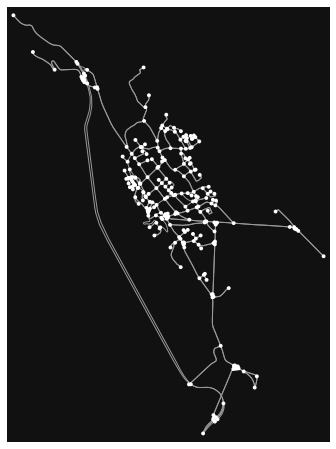

In [27]:
fig, ax = ox.plot_graph(G)
plt.show()

In [28]:
import networkx as nx

In [29]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

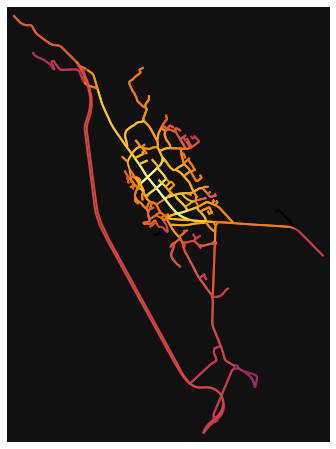

In [30]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)
plt.show()

# Find the shortest path between 2 points by minimizing travel time


## calculate the travel time for each edge

### define the origin and destination

... for exampe the highschool and the train stationg of Mezzolombardo


**highschool**

[Martino Martini Institute](https://www.openstreetmap.org/?mlat=46.21751&mlon=11.09344#map=17/46.21751/11.09344)

lat: 46.21751<br/>
lon: 11.09344


**train station**

[Train Station FTM](https://www.openstreetmap.org/?mlat=46.2133&mlon=11.0934#map=16/46.2133/11.0934)

lat: 46.2133<br/>
lon: 11.0934





## find the node on the graph nearest on the point given

thes two points are NOT on the graph.

We need to find the nodes nearest

In [31]:
point_school =  (46.21751, 11.09344)
point_trainstation = (46.2133, 11.0934)

In [ ]:
point_nearest_school = ox.get_nearest_node(G, point_school)
point_nearest_trainstation = ox.get_nearest_node(G, point_trainstation)

### calculate the time to walk over each edges

In [33]:
G = ox.graph_from_place(place_name, network_type='walk')

plot the walkable street network

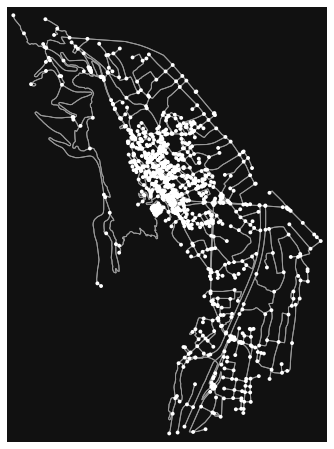

In [34]:
fig, ax = ox.plot_graph(G)
plt.show()

In [35]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

... geopandas investigation

In [36]:
edges = ox.graph_to_gdfs(G,edges=True,nodes=False)

In [37]:
edges.head(3)

osmid   ref  ... access tunnel
u        v          key                  ...              
82450966 1669326208 0    30275775  SS43  ...    NaN    NaN
         268811327  0    30275775  SS43  ...    NaN    NaN
         392889118  0    34257473   NaN  ...    NaN    NaN

[3 rows x 16 columns]

In [38]:
edges.columns

Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'length',
       'speed_kph', 'travel_time', 'geometry', 'service', 'junction', 'lanes',
       'bridge', 'access', 'tunnel'],
      dtype='object')

In [39]:
edges[edges.travel_time == edges.travel_time.max()].name

u           v           key
389537031   8464430205  0      NaN
8464430205  389537031   0      NaN
Name: name, dtype: object

In [40]:
edges[edges.travel_time == edges.travel_time.max()].osmid

u           v           key
389537031   8464430205  0      34004791
8464430205  389537031   0      34004791
Name: osmid, dtype: object

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/osmid_3400471.jpg)

https://www.openstreetmap.org/way/34004791

## find the shortest path between the train station and the school 

In [41]:
route = ox.shortest_path(G, point_nearest_trainstation, point_nearest_school, weight='travel_time')

In [42]:
route

[388416104,
 885639428,
 1305986901,
 1305986871,
 2274146551,
 937561848,
 861050486,
 1168688867,
 861049754,
 388416092,
 861049817,
 1168688982,
 276977978,
 276977352,
 276977351,
 331259712,
 1168689199,
 1168688986,
 331259708,
 276977130,
 973022445,
 2249094490,
 276977119]

these values are the ids of each node of the graph

In [43]:
G.nodes[388416104]

{'street_count': 3, 'x': 11.0933838, 'y': 46.2133289}

In [44]:
nodes = ox.graph_to_gdfs(G,edges=False,nodes=True)

In [45]:
nodes

,y,x,street_count,highway,geometry
osmid,,,,,
82450966,46.208696,11.102124,3,NaN,POINT (11.10212 46.20870)
267649319,46.208188,11.113020,4,NaN,POINT (11.11302 46.20819)
267649323,46.208211,11.112359,3,NaN,POINT (11.11236 46.20821)
267649326,46.207974,11.113296,3,NaN,POINT (11.11330 46.20797)
268811289,46.185223,11.105923,3,NaN,POINT (11.10592 46.18522)
...,...,...,...,...,...
8672128764,46.210742,11.091513,3,NaN,POINT (11.09151 46.21074)
8672128813,46.210012,11.091789,1,NaN,POINT (11.09179 46.21001)
8672128816,46.210124,11.092145,4,NaN,POINT (11.09214 46.21012)


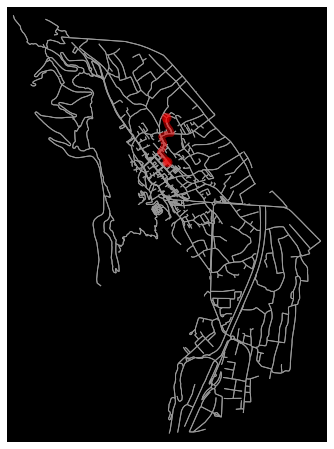

In [46]:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')
plt.show()


In [47]:
ox.plot_route_folium(G,route,popup_attribute='name',tiles='OpenStreetMap')

how long is our route in meters?

In [48]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

753.9340000000001

how many minutes does it take?

In [54]:
import datetime

In [49]:
edge_times = ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')
seconds = sum(edge_times)

In [50]:
seconds

115.9

In [55]:
str(datetime.timedelta(seconds=seconds))

'0:01:55.900000'

## calculate bearing

Calculate the compass bearing from origin node to destination node for each edge in the directed graph then add each bearing as a new edge attribute. Bearing represents angle in degrees (clockwise) between north and the direction from the origin node to the destination node.
<br/><br/>


In [52]:
cols = ['city']
names = [('Roma'),('Trento'),('Genova'),('Trieste')]
cities = gpd.GeoDataFrame(names,columns=cols)
geo_cities = gpd.tools.geocode(cities.city, provider="arcgis")

In [53]:
cities

,city
0,Roma
1,Trento
2,Genova
3,Trieste


In [56]:
geo_cities

,geometry,address
0,POINT (12.49565 41.90322),Roma
1,POINT (11.11929 46.07005),Trento
2,POINT (8.93917 44.41048),Genova
3,POINT (13.77269 45.65757),Trieste


In [57]:
geo_cities.explore()

In [58]:
trento = geo_cities[geo_cities.address == 'Trento'].geometry

In [60]:
trento.geometry.x.values[0]

11.119290000000035

In [61]:
trento_point = (trento.geometry.y.values[0],trento.geometry.x.values[0])

In [62]:
trento_point

(46.07005000000004, 11.119290000000035)

In [63]:
roma_point = (geo_cities[geo_cities.address == 'Roma'].geometry.y.values[0], geo_cities[geo_cities.address == 'Roma'].geometry.x.values[0])
genova_point = (geo_cities[geo_cities.address == 'Genova'].geometry.y.values[0], geo_cities[geo_cities.address == 'Genova'].geometry.x.values[0])
trieste_point = (geo_cities[geo_cities.address == 'Trieste'].geometry.y.values[0], geo_cities[geo_cities.address == 'Trieste'].geometry.x.values[0])

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Compass_Card_B%2BW.svg/480px-Compass_Card_B%2BW.svg.png)

In [64]:
#Trento - Roma
ox.bearing.get_bearing(trento_point,roma_point)

/usr/local/lib/python3.7/dist-packages/osmnx/bearing.py:77: UserWarning: The `get_bearing` function has been deprecated and will be removed in a future release. Use the vectorized `bearing.calculate_bearing` instead.
  warnings.warn(msg)


166.14931950629008

In [65]:
#Trento - Trieste
ox.bearing.get_bearing(trento_point,trieste_point)

/usr/local/lib/python3.7/dist-packages/osmnx/bearing.py:77: UserWarning: The `get_bearing` function has been deprecated and will be removed in a future release. Use the vectorized `bearing.calculate_bearing` instead.
  warnings.warn(msg)


101.62965042129908

In [66]:
#Trento - Genova
ox.bearing.get_bearing(trento_point,genova_point)

/usr/local/lib/python3.7/dist-packages/osmnx/bearing.py:77: UserWarning: The `get_bearing` function has been deprecated and will be removed in a future release. Use the vectorized `bearing.calculate_bearing` instead.
  warnings.warn(msg)


223.54736298562963

# PyORSM

## Network Analysis with PyORSM + OSMnx + NetworkX

In [67]:
url_download_mezzolombardo_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/022117_Mezzolombardo_poly.osm.pbf'
import urllib.request
urllib.request.urlretrieve(url_download_mezzolombardo_pbf ,"mezzolombardo_osm.pbf")

('mezzolombardo_osm.pbf', <http.client.HTTPMessage at 0x7fd3bfe44310>)

In [68]:
osm = pyrosm.OSM("mezzolombardo_osm.pbf") 

In [69]:
nodes, edges = osm.get_network(nodes=True)

## NetworkX
calculate the distances between the highschool and the train station

In [70]:
G = osm.to_graph(nodes, edges, graph_type="networkx")

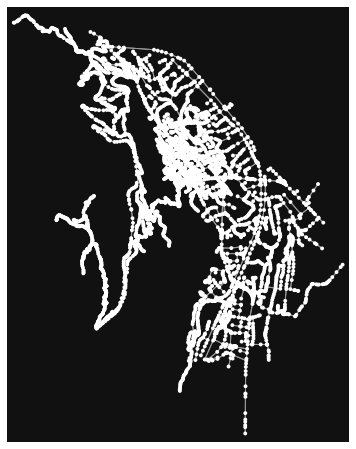

In [71]:
ox.plot_graph(G)
plt.show()

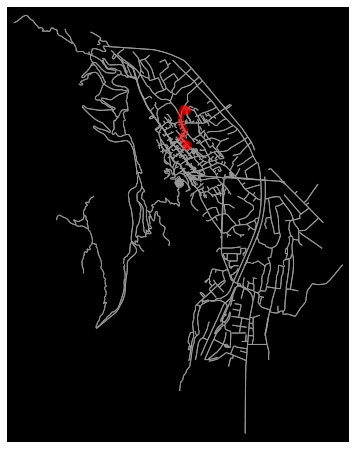

In [72]:
#eg. lenght
route = ox.shortest_path(G, point_nearest_trainstation, point_nearest_school, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')
plt.show()

### Let’s start by defining a few helper functions for our analysis:

## PyORSM + Pandana
### Calculate the job accessibility in Mezzolombardo - Italy with pyrosm and pandana
(based on pyroms tutorial)

Pandana is a third Python network analysis library supported by pyrosm export functionality at the time of writing. Pandana operates using a fast (contraction hierarchies)[https://en.wikipedia.org/wiki/Contraction_hierarchies]-algorithm and includes various useful functions.<br/>In this tutorial, we will see 
- 1 how to calculate distance to nearest 5 supermarkets for each network node in the city of Mezzolombardo - Italy
- 2 how to calculate a simple job accessibility index for the city based on number of supermarkets employees (simulated).

In [73]:
import numpy as np

In [74]:
import pandana

In [75]:
nodes, edges = osm.get_network(network_type="driving", nodes=True)
supermarkets = osm.get_pois(custom_filter={"shop": ["supermarket"]})

In [76]:
G = osm.to_graph(nodes, edges, graph_type="pandana")

In [77]:
# For simplicity, ensure all restaurants are represented as points
supermarkets["geometry"] =supermarkets.representative_point().geometry
supermarkets["lat"] = supermarkets.geometry.y
supermarkets["lon"] = supermarkets.geometry.x


In [78]:
# Precompute distances up to 2000 meters
# Notice using long distance with large network can consume memory quite a bit
G.precompute(2000)

## Find nearest X number of POIs for each network node

After we have done precalculations with pandana, it allows conducting performant queries, such as querying distances to X number of nearest supermarkets for all network nodes.<br/>

The following example shows how to find the 5 closest restaurants from each network node (up to 2000 meter distance threshold):

In [79]:
# Attach supermarkets to Pandana graph
G.set_pois(category="supermarkets", maxdist=2000, maxitems=10, 
           x_col=supermarkets.lon, y_col=supermarkets.lat)

In [80]:
# For each node in the network find distances to 5 closest restaurants (up to 2000 meters)
nearest_five = G.nearest_pois(2000, "supermarkets", num_pois=5)
nearest_five.head(10)

,1,2,3,4,5
7855180990,1682.196045,1900.250977,2000.0,2000.0,2000.0
268811302,1675.369995,1893.425049,2000.0,2000.0,2000.0
1066710417,1668.616943,1886.671997,2000.0,2000.0,2000.0
268811297,1661.859009,1879.913940,2000.0,2000.0,2000.0
1066710892,1655.097046,1873.151978,2000.0,2000.0,2000.0
7855180986,1648.344971,1866.400024,2000.0,2000.0,2000.0
7855180987,1641.584961,1859.640015,2000.0,2000.0,2000.0
268811298,1634.824951,1852.880005,2000.0,2000.0,2000.0
1066710659,1760.697998,1978.753052,2000.0,2000.0,2000.0
7855180988,1754.162964,1972.218018,2000.0,2000.0,2000.0


As a result, we get the distance to five nearest supermarket for each node (node-id is the `index` here).

In [81]:
nearest_five[2].sort_values().index[0]

1226777913

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/node_1226777913.jpg)
[https://www.openstreetmap.org/node/1226777913](https://www.openstreetmap.org/node/1226777913)

### Calculate the job accessibility
Next we will use a useful pandana function called `aggregate` that allows to calculate accessibility index based on a given numeric variable, such as employee count. 

Here, we won’t be using any real employee information, but assign a random number of employees for each supermarket (between 10-50). 

Then we will calculate a specific job accessibility index based on cumulative number of supermarkets employees within 500 meters (from each network node). 

This kind of index can provide a nice overview of the (supermarkets) job accessibility in a city.

In [82]:
# Assign a random number of workers for each supermarkets (between 10-50)
supermarkets["employee_cnt"] = np.random.choice([x for x in range(10,50)], size=len(supermarkets))


In [83]:
# Find the closest node-id for each restaurant
node_ids = G.get_node_ids(supermarkets.lon, supermarkets.lat)

In [84]:
# Add employee counts to the graph
G.set(node_ids, variable=supermarkets.employee_cnt, name="employee_cnt")

In [85]:
# Calculate the number of employees (cumulative sum) from each node up to 500 meters
result = G.aggregate(500, type="sum", decay="linear", name="employee_cnt")
result = result.to_frame(name="cum_employees")

In [86]:
# Attach the information from nodes
result = nodes.merge(result, left_on="id", right_on=result.index)

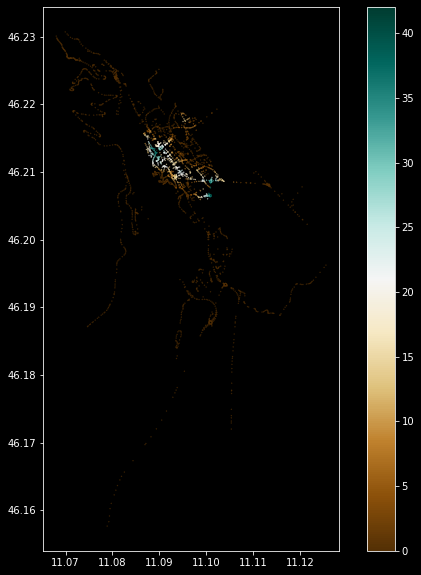

In [87]:
# Visualize the results
plt.style.use('dark_background')
ax = result.plot(column="cum_employees", cmap='BrBG', markersize=0.1, legend=True, figsize=(10, 10))
plt.show()

As a result, we get a map showing the supermarket job accessibility in Mezzolombardo - Italy.<Br/>
The highlighted colors show areas where there are high number of supermarket jobs/employees working (notice that this is not based on real data).

---

# Exercise

- identify the shortest path by walk to reach the Castle of Trento from the main train station of Trento
- identify how many bars you can reach by walking in 5 minutes from the main train station of Trento
- calculate the students (primary and secondary education) accessibility of the city of Trento
- identify the streets network orientation of the cities: Trento - Italy, Udine - Italy,  Trieste - Italy, Bari - Italy, Cremona - Italy, Bergamo - Italy, Chengdu - China, Istanbul - Turkey 